In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue 
import math

In [2]:
Number_Of_Nodes = 20

In [3]:
prev_pheromone = [[1 for _ in range(Number_Of_Nodes)] for _ in range(Number_Of_Nodes)]

In [4]:
class Node:
    """
    Node Class contains the name of the node, the x and y coordinated, the quota present at the node and the time required to 
    get that quota
    """
    def __init__(self, name, coord, quota, time_req):
        self.name = name
        self.coord = coord
        self.quota = quota
        self.time_req = time_req

In [5]:
class Graph:
    """
    The Graph contains the adjacency list, the cost of all edges, the time required to traverse the edges, the pheromone level
    of the edges and the list of the nodes.
    """
    def __init__(self):
        self.AdjacencyList = {}
        self.Cost = {}
        self.Time_Req = {}
        self.NodeList = []
        self.Pheromones = {}
        
    def distance(self, point1, point2):
        """
        Calculates the euclidean distance between two points
        """
        return np.sqrt(np.sum((point1 - point2)**2))
    
    def add_node(self, node):
        """
        Adding a node to the graph
        """
        self.AdjacencyList[node.name] = set()
        self.NodeList.append(node)
        
    def add_edge(self, node1, node2, time):
        """
        Adding an edge to the graph
        """
        self.Pheromones[(node1.name, node2.name)] = 1
        self.Pheromones[(node2.name, node1.name)] = 1
        
        self.AdjacencyList[node1.name].add(node2)
        self.AdjacencyList[node2.name].add(node1)
        
        self.Cost[(node1.name, node2.name)] = self.distance(node1.coord, node2.coord)
        self.Cost[(node2.name, node1.name)] = self.distance(node1.coord, node2.coord)
        
        self.Time_Req[(node1.name, node2.name)] = time
        self.Time_Req[(node2.name, node1.name)] = time
        
    def plot(self):
        """
        Visuals for easier understanding, plots the graph with node their names, costs and time required and edges with their
        costs.
        """
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111)
        
        for i in self.NodeList:
            ax.plot(i.coord[0], i.coord[1], color = 'r', marker = 'o')
            ax.annotate(i.name, (i.coord[0] + 0.010, i.coord[1] + 0.050))
            ax.annotate("Qu: " + str(round(i.quota,2)), (i.coord[0] + 0.010, i.coord[1] + 0.030))
            ax.annotate("Ti: " + str(round(i.time_req,2)), (i.coord[0] + 0.010, i.coord[1] + 0.010))
            
        for i in range(len(self.NodeList)):
            for j in range(len(self.NodeList)):
                N1, N2 = self.NodeList[i], self.NodeList[j]
                if N1 in self.AdjacencyList[N2.name]:
                    ax.plot([N1.coord[0], N2.coord[0]], [N1.coord[1], N2.coord[1]], color='g')
                    X1 = (N1.coord[0] + N2.coord[0])/2
                    Y1 = (N1.coord[1] + N2.coord[1])/2
                    
                    angle = (N2.coord[1]-N1.coord[1])/(N2.coord[0]-N1.coord[0])
                    angle = math.atan(angle)
                    angle = 180*angle/3.14159
                    ax.annotate(round(self.Cost[(N1.name,N2.name)],2), (X1,Y1), rotation = angle)

In [6]:
class Passengers:
    """
    Each passenger has a pickup and destination nodes, a budget(maximum amount of money willing to spend), max duration of time
    the passenger is willing to travel, and penalties of dropping passenger to any other node except the destination
    """
    def __init__(self, pickup, destination, budget, max_duration, penalties):
        self.pickup = pickup
        self.destination = destination
        self.budget = budget
        self.max_duration = max_duration
        self.penalties = penalties

In [7]:
def calculate_penalties(pickup, destination, Gph):
    """
    Calculates penalties for a single passenger for every node except the destination and pickup.
    The penalty is the distance of the node to the destination
    """
    Nodes = Gph.NodeList
    Cost = Gph.Cost
    
    penalties = {}
    
    for i in Nodes:
        if i.name==pickup.name or i.name==destination.name:
            continue
            
        penalties[i.name] = Cost[(i.name, destination.name)]
        
    return penalties

In [8]:
class Multi_Strategy_Ant_Colony_Optimization:
    """
    Class to implement MSACO contains the Graph, the list of passenger, the source node, number of ants, number of iterations, 
    evaporation rate, minimum quota the passenger has to achieve and the maximum number of seats in the vehicle
    """
    def __init__(self, Gph, PassengerList, source, num_ants, num_iterations, eva_rate, min_quota, max_seats, prev_pheromone, Node_dict, alpha=1, beta=1, gamma=0):
        self.Gph = Gph
        self.PassengerList = PassengerList
        self.source = source
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.eva_rate = eva_rate
        self.min_quota = min_quota
        self.max_seats = max_seats
        self.prev_pheromone = prev_pheromone
        self.Node_dict = Node_dict
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.Heuristic_strategies = ["Cost", "Time", "Quota", "Passengers"]
        
    def calculate_probabilities(self, current_node, adjacent_unvisited_nodes, strategy):
        """
        Uses the multi-stategy algorithm to calculate the probability of the current ant to visit any of the adjacent 
        unvisited nodes.
        """
        sm = 0
        N = len(adjacent_unvisited_nodes)
        probabilities = np.zeros(N)
        
        for i in range(N):
            adj_node = adjacent_unvisited_nodes[i]
            if strategy=="Cost":
                probabilities[i] = 1/((self.Gph.Cost[(adj_node.name, current_node.name)])**self.alpha)
            if strategy=="Time":
                probabilities[i] = 1/(self.Gph.Time_Req[(adj_node.name, current_node.name)])
            if strategy=="Quota":
                probabilities[i] = adj_node.quota/(self.Gph.Cost[(adj_node.name, current_node.name)])
            if strategy=="Passengers":
                num = 0
                for j in self.Gph.PassengerList:
                    if current_node.name == j.pickup.name:
                        num += 1
                probabilities[i] = num/(self.Gph.Cost[(adj_node.name, current_node.name)])
                
                
            probabilities[i] *= (self.Gph.Pheromones[(current_node.name, adj_node.name)]**self.beta)
            probabilities[i] *= (self.prev_pheromone[self.Node_dict[current_node.name]][self.Node_dict[adj_node.name]]**self.gamma)
                
            sm += probabilities[i]
            
        probabilities /= sm
        
        return probabilities
    
    
        
    def plot(self, best_path):
        """
        Visuals for better understanding, plots the nodes and the best path.
        """
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111)
        
        for i in self.Gph.NodeList:
            ax.plot(i.coord[0], i.coord[1], color = 'r', marker = 'o')
            ax.annotate(i.name, (i.coord[0] + 0.010, i.coord[1] + 0.050))
            ax.annotate("Qu: " + str(round(i.quota,2)), (i.coord[0] + 0.010, i.coord[1] + 0.030))
            ax.annotate("Ti: " + str(round(i.time_req,2)), (i.coord[0] + 0.010, i.coord[1] + 0.010))
            
        ax.plot([best_path[0].coord[0]], [best_path[0].coord[1]], c='g', marker='*', ms = 20)
            
            
        for i in range(len(best_path)-1):
            N1, N2 = best_path[i], best_path[i+1]
            ax.arrow(N1.coord[0],N1.coord[1],N2.coord[0]-N1.coord[0],N2.coord[1]-N1.coord[1], length_includes_head = True, head_width=0.008, head_length=0.02, color='green')
            X1 = (N1.coord[0] + N2.coord[0])/2
            Y1 = (N1.coord[1] + N2.coord[1])/2

            angle = (N2.coord[1]-N1.coord[1])/(N2.coord[0]-N1.coord[0])
            angle = math.atan(angle)
            angle = 180*angle/3.14159
            ax.annotate(round(self.Gph.Cost[(N1.name,N2.name)],2), (X1,Y1), rotation = angle)
            
        N1, N2 = best_path[-1], best_path[0]
        ax.arrow(N1.coord[0],N1.coord[1],N2.coord[0]-N1.coord[0],N2.coord[1]-N1.coord[1], length_includes_head = True, head_width=0.008, head_length=0.02, color='green')
        X1 = (N1.coord[0] + N2.coord[0])/2
        Y1 = (N1.coord[1] + N2.coord[1])/2

        angle = (N2.coord[1]-N1.coord[1])/(N2.coord[0]-N1.coord[0])
        angle = math.atan(angle)
        angle = 180*angle/3.14159
        ax.annotate(round(self.Gph.Cost[(N1.name,N2.name)],2), (X1,Y1), rotation = angle)
    
    
    def get_drop_off(self, curr_path, passenger, curr_passengers):
        """
        Gets the best possible drop off point of the current passenger in the given curr_path.
        """
        i = 0
        tot_passengers_sitting = 1
        for i in range(len(curr_path)):
            tot_passengers_sitting += curr_passengers[i] 
            if curr_path[i].name == passenger.pickup.name:
                if (tot_passengers_sitting+1) == self.max_seats:
                    return 0
                tot_passengers_sitting += 1
                break
        
        best_pay = 0
        best_penalty = 0
        node = -1
        pickup = i
        
        curr_pay = 0
        curr_penalty = 0
        curr_time = curr_path[i].time_req
        
        i += 1
        while i<len(curr_path):    
            curr_time += (self.Gph.Time_Req[(curr_path[i].name, curr_path[i-1].name)] + curr_path[i].time_req)
            curr_pay += (self.Gph.Cost[(curr_path[i].name, curr_path[i-1].name)]/tot_passengers_sitting)
            if curr_time>passenger.max_duration or curr_pay>passenger.budget:
                return 0
            
            if curr_path[i].name == passenger.destination.name:
                curr_penalty = 0
            else:
                curr_penalty = (passenger.penalties[curr_path[i].name])
                
            if (curr_pay-curr_penalty)>(best_pay-best_penalty):
                best_pay = curr_pay
                best_penalty = curr_penalty
                node = i
                
            curr_time += curr_path[i].time_req
            tot_passengers_sitting += curr_passengers[i]
            if curr_time>passenger.max_duration or (tot_passengers_sitting+1) == self.max_seats:
                return 0
            
            i += 1
                          
        total_cost_reduced = best_pay - best_penalty
        if node!=-1:
            curr_passengers[pickup] += 1
            if (node+1)<len(curr_passengers):
                curr_passengers[node+1] -= 1
                
        return total_cost_reduced
                  
        
    def RMH(self, curr_path):
        """
        Implements the Ride Matching Heuristic algorithm to find out the maximum reward that can be acquired given a path
        and the list of passengers.
        """
        curr_passengers = [0]*len(curr_path)
        Total_Reward = 0
        
        passengers = []
        
        for i in self.PassengerList:
            passengers.append((i.budget, i))
            
        passengers.sort()
        
        for i in range(len(passengers)-1, -1, -1):
            _, passenger = passengers[i]
            
            is_in_path = False
            
            for j in curr_path:
                if j.name == passenger.pickup.name:
                    is_in_path = True
                    break
            
            if not is_in_path:
                continue
                
            Total_Reward += self.get_drop_off(curr_path, passenger, curr_passengers)
                
        
        return Total_Reward
    
    def ACO(self):
        """
        Implements the Ant Colony Optimization algorithm to find the path, then uses the RMH algorithm (implemented above)
        to find the reward on the current path.
        """
        best_path = None
        best_cost = np.inf
        best_quota = 0
        best_reward = 0

        for iterate in range(self.num_iterations):
            curr_paths = []
            curr_lengths = []
            curr_quotas = []

            for ant in range(self.num_ants):
                visited = set()
                current_p = self.source
                visited.add(current_p.name)
                curr_path = [current_p]
                curr_length = 0
                curr_quota = 0
                curr_quota += current_p.quota
            
                while curr_quota+0.00001<min_quota:
#                     print(curr_quota, min_quota)
                    adjacent_unvisited_nodes = []
                    for i in self.Gph.AdjacencyList[current_p.name]:
                        if i.name not in visited:
                            adjacent_unvisited_nodes.append(i)
                            
                    strategy = self.Heuristic_strategies[np.random.randint(0,3)]
#                     strategy = self.Heuristic_strategies[0]
                            
                    probabilities = self.calculate_probabilities(current_p, adjacent_unvisited_nodes, strategy)

                    next_p = np.random.choice(adjacent_unvisited_nodes, p=probabilities)

                    curr_path.append(next_p)
                    curr_length = curr_length + self.Gph.Cost[(current_p.name, next_p.name)]
                    curr_quota += next_p.quota

                    visited.add(next_p.name)
                    current_p = next_p
                

                curr_paths.append(curr_path)
                curr_lengths.append(curr_length)
                curr_quotas.append(curr_quota)

                curr_cost, curr_reward = curr_length, self.RMH(curr_path)
                if (curr_cost-curr_reward)<(best_cost-best_reward):
                    best_cost = curr_cost
                    best_path = curr_path
                    best_quota = curr_quota
                    best_reward = curr_reward
                    for j in range(len(curr_path)-1):
                        self.Gph.Pheromones[(curr_path[j].name, curr_path[j+1].name)] += (1/curr_length)
                        self.Gph.Pheromones[(curr_path[j+1].name, curr_path[j].name)] += (1/curr_length)
                    self.Gph.Pheromones[(curr_path[0].name, curr_path[-1].name)] += (1/curr_length)
                    self.Gph.Pheromones[(curr_path[-1].name, curr_path[0].name)] += (1/curr_length)
                    
            for i in self.Gph.Pheromones.keys():
                self.Gph.Pheromones[i] *= eva_rate

        best_length = len(best_path)
        for j in range(len(best_path)-1):
            self.prev_pheromone[self.Node_dict[best_path[j].name]][self.Node_dict[best_path[j+1].name]] += (1/best_length)
            self.prev_pheromone[self.Node_dict[best_path[j+1].name]][self.Node_dict[best_path[j].name]] += (1/best_length)
        self.prev_pheromone[self.Node_dict[best_path[0].name]][self.Node_dict[best_path[-1].name]] += (1/best_length)
        self.prev_pheromone[self.Node_dict[best_path[-1].name]][self.Node_dict[best_path[0].name]] += (1/best_length)


        for i in range(len(self.prev_pheromone)):
            for j in range(len(self.prev_pheromone[i])):
                prev_pheromone[i][j] *= eva_rate
            
            
        
        best_path_names = []
        for i in best_path:
            best_path_names.append(i.name)
            
        print("Path:" + str(best_path_names))
        print("Min Quota:" + str(self.min_quota))
        print("Achieved Quota:" + str(best_quota))
        print("Cost:" + str(best_cost))
        print("Reward:" + str(best_reward))
        print("Total Cost:" + str(best_cost - best_reward))
        
        self.plot(best_path)
            

In [9]:
def createGraph():
    """
    Creates a random graph, with random quota on each node and random time required to get the quota
    """
    Gph = Graph()
    Nodes = []
    Coordinates = np.random.rand(Number_Of_Nodes, 2)
    quota_sum = 0
    first_name = "A"
    second_name = "A"
    for i in range(Number_Of_Nodes):
        name = first_name + second_name
        if second_name == "Z":
            second_name = "A"
            first_name = chr(ord(first_name) + 1)
        else:
            second_name = chr(ord(second_name) + 1)
        quota, time =  round(np.random.random(),4), np.random.random()

        Nodes.append(Node(name, Coordinates[i], quota, time))
        quota_sum += quota

    for i in Nodes:
        Gph.add_node(i)
        
    Node_dict = {}
    for ind, i in enumerate(Nodes):
        Node_dict[i.name] = ind
        
    tot_distance = 0
    
    for i in range(0,Number_Of_Nodes):
        for j in range(0,i):
            node1, node2 = Nodes[i], Nodes[j]
            tot_distance += Gph.distance(node1.coord, node2.coord)

    for i in range(0,Number_Of_Nodes):
        for j in range(0,i):
            node1, node2 = Nodes[i], Nodes[j]
            time = np.random.random()*Gph.distance(node1.coord, node2.coord)/tot_distance
            Gph.add_edge(node1, node2, time)
            
            
    return Node_dict, Gph, quota_sum

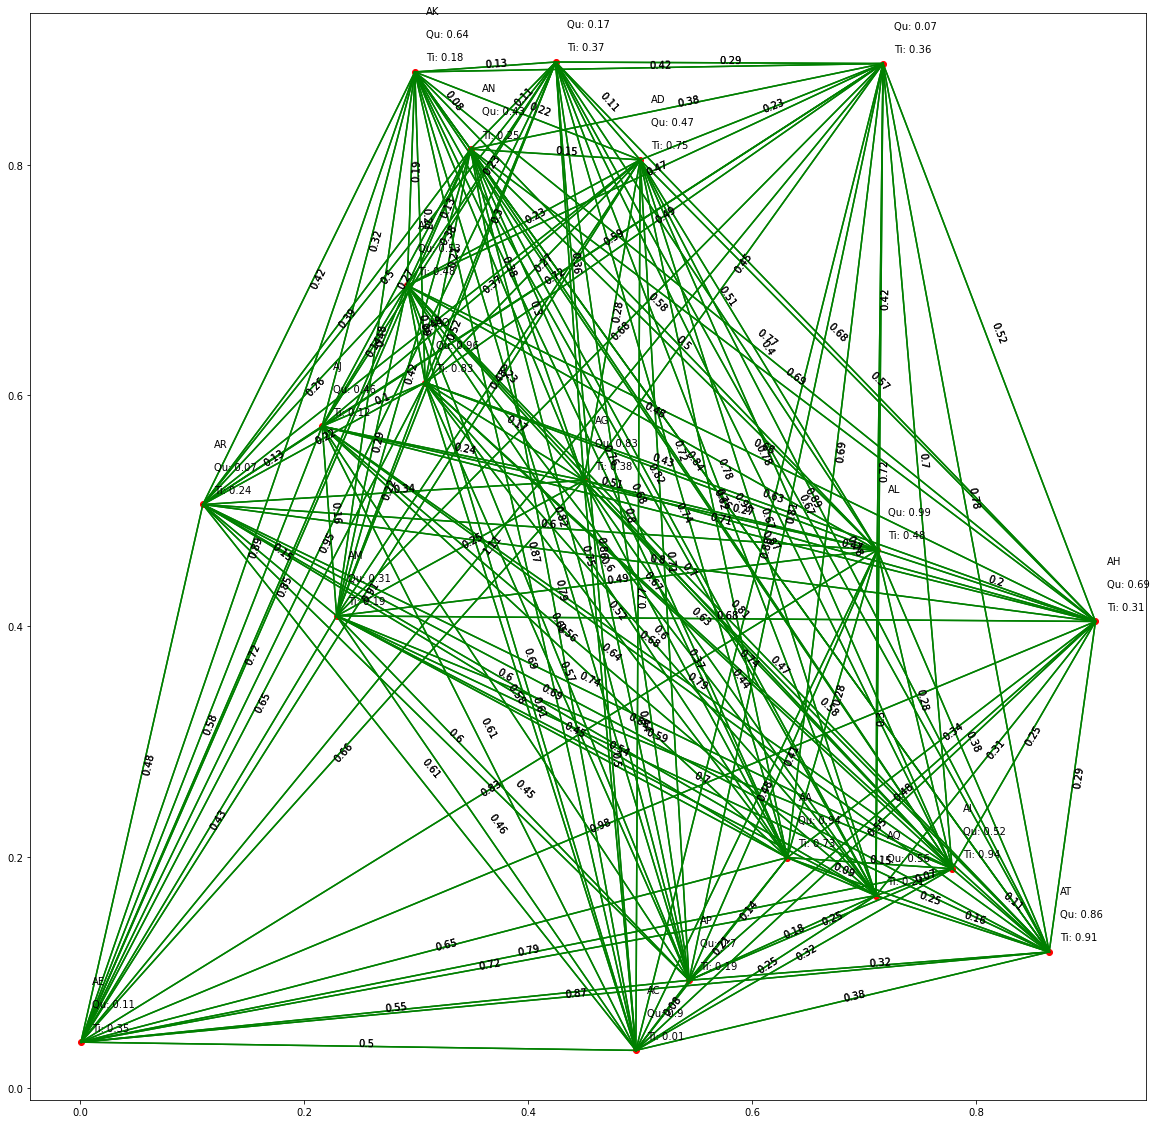

In [10]:
Node_dict, Gph, min_quota = createGraph()
Gph.plot()

In [11]:
def Create_Passengers(Gph, num_passengers):
    """
    Created the passengers. Each passenger has a random pickup, drop-off points, budget and maximum duration.
    """
    Nodes = Gph.NodeList
    PassengerList = []
    for i in range(num_passengers):
        pickup, destination = Nodes[np.random.randint(0,len(Nodes)-1)], Nodes[np.random.randint(0,len(Nodes)-1)]
        budget = np.random.random()*20
        max_duration = np.random.random()*20
        penalties = calculate_penalties(pickup, destination, Gph)
        
        PassengerList.append(Passengers(pickup, destination, budget, max_duration, penalties))
        
    return PassengerList

In [12]:
PassengerList = Create_Passengers(Gph, 3*Number_Of_Nodes)

In [13]:
source = Gph.NodeList[0]
num_ants = 100
num_iterations = 500
eva_rate = 0.5
max_seats = 4

In [14]:
MSACO = Multi_Strategy_Ant_Colony_Optimization(Gph, PassengerList, source, num_ants, num_iterations, eva_rate, min_quota, max_seats, prev_pheromone, Node_dict)

Path:['AA', 'AG', 'AJ', 'AO', 'AD', 'AS', 'AF', 'AN', 'AK', 'AB', 'AL', 'AH', 'AT', 'AI', 'AQ', 'AC', 'AP', 'AE', 'AM', 'AR']
Min Quota:11.226000000000003
Achieved Quota:11.226
Cost:4.503460403756494
Reward:1.9879760892369025
Total Cost:2.515484314519591


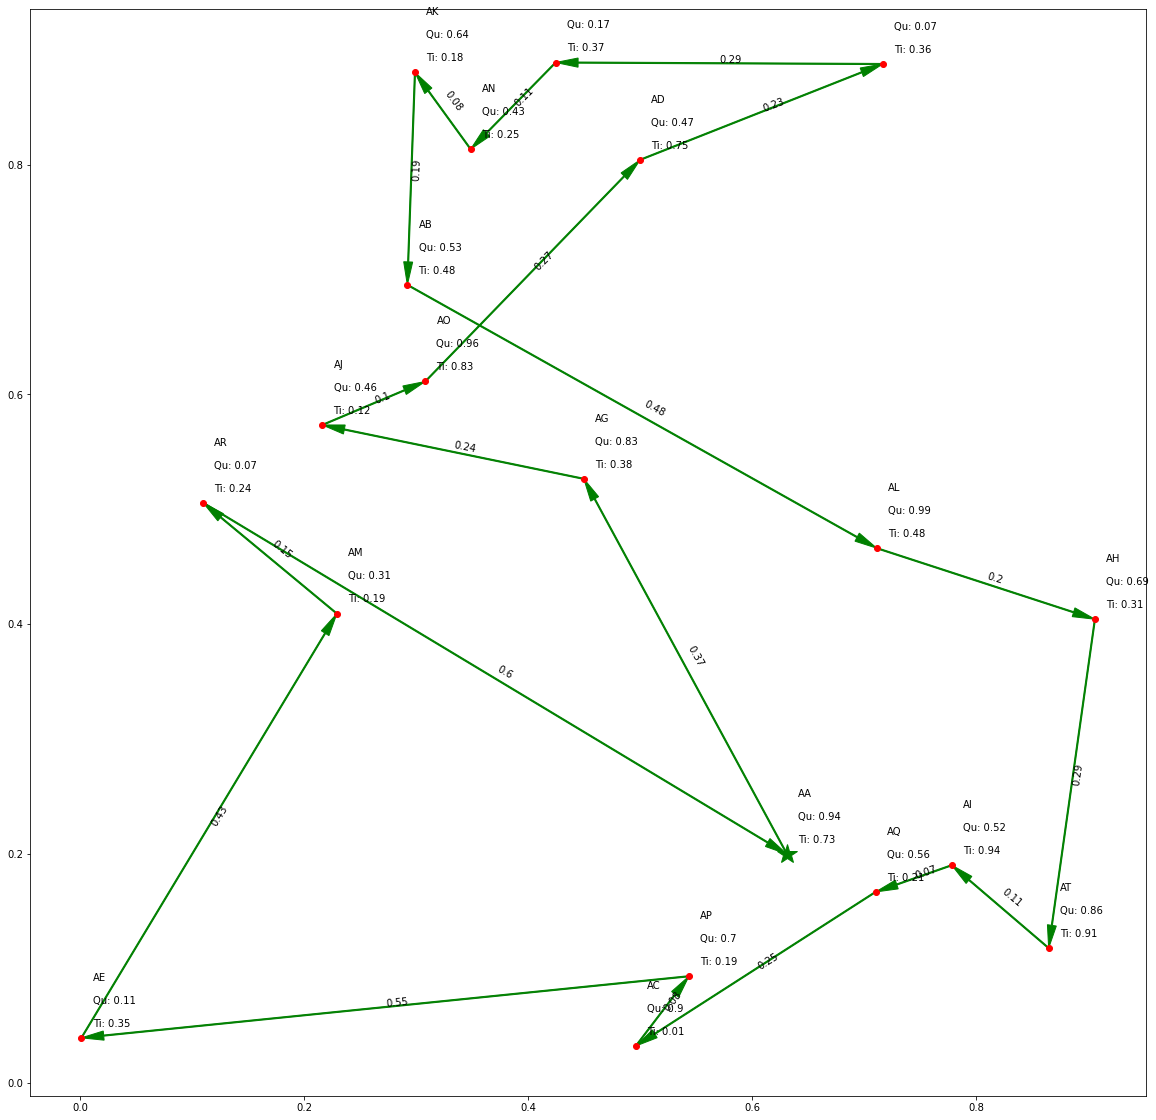

In [15]:
MSACO.ACO()